### loading & unzipping dataset from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/UPC/AML_Project2/EuroSAT_RGB.zip /content/

In [3]:
!unzip EuroSAT_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: EuroSAT_RGB/Residential/Residential_489.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_1573.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_270.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_516.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2683.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_502.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2697.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_264.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2867.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2873.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_258.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2126.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_1349.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2640.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2898.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2654.j

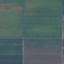

In [4]:
from PIL import Image

Image.open('EuroSAT_RGB/AnnualCrop/AnnualCrop_140.jpg')

### preparing the dataset

In [5]:
import os

classes = [f.path.split('/')[1] for f in os.scandir('EuroSAT_RGB') if f.is_dir()]

In [6]:
# Number of samples per class:

In [8]:
image_paths = []
image_labels = []

for i, c in enumerate(classes):
  class_paths = [f.path for f in os.scandir(f'EuroSAT_RGB/{c}')]
  image_paths += class_paths
  image_labels += [i] * len(class_paths)
  print(c, len(class_paths))

PermanentCrop 2500
Highway 2500
River 2500
Forest 3000
Residential 3000
AnnualCrop 3000
HerbaceousVegetation 3000
Industrial 2500
Pasture 2000
SeaLake 3000


In [9]:
import numpy as np
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [11]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':8,
    'num_epochs':200, # high number of epochs since we use early stopping
    'test_batch_size':64,
    'num_classes':10,
    'learning_rate':1e-5,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class EurosatDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_paths = img_paths
        self.transform = transforms.Compose([
            transforms.ConvertImageDtype(torch.float)
        ]) if transform is None else transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = EurosatDataset(img_paths=image_paths,
                         img_labels=image_labels)

### Train val test split, prepare dataloader

In [13]:
from torch.utils.data import DataLoader, random_split

# Define the sizes for train, validation, and test sets
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80% for training
valid_test_size = dataset_size - train_size  # 20% for validation and testing
valid_size = test_size = int(valid_test_size / 2)  # Splitting the remaining 20% equally for validation and testing

# Splitting the dataset
train_dataset, valid_test_dataset = random_split(dataset, [train_size, valid_test_size])
valid_dataset, test_dataset = random_split(valid_test_dataset, [valid_size, test_size])

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset,
                          batch_size=hparams['batch_size'],
                          shuffle=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=hparams['batch_size'],
                          shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=hparams['batch_size'],
                         shuffle=False)

print(len(train_dataset), len(valid_dataset), len(test_dataset))

21600 2700 2700


### Define architecture of different networks

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer
        self.fc1 = nn.Linear(8 * 8 * 64, 512)
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.dropout(x, 0.25)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [15]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256)  # Flatten the tensor
        x = F.dropout(F.relu(self.fc1(x)), 0.5)
        x = F.dropout(F.relu(self.fc2(x)), 0.5)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = AlexNet()
print(model)

AlexNet(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


### Train epoch with early stopping & checkpointing

In [16]:
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

def validate_epoch(valid_loader, network, criterion, hparams):
    network.eval()
    device = hparams['device']
    valid_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            valid_loss += criterion(output, target).item() * data.size(0)
            acc += correct_predictions(output, target)
    valid_loss /= len(valid_loader.dataset)
    valid_acc = 100. * acc / len(valid_loader.dataset)
    return valid_loss, valid_acc

def train_epoch(epoch, train_loader, valid_loader, network, optimizer, criterion, hparams):
    network.train()
    device = hparams['device']
    avg_loss = None
    avg_weight = 0.1

    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch}', unit='batch')

    for batch_idx, (data, target) in enumerate(train_loader_tqdm):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if avg_loss is not None:
            avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
            avg_loss = loss.item()

        train_loader_tqdm.set_postfix(loss=avg_loss)

    valid_loss, valid_acc = validate_epoch(valid_loader, network, criterion, hparams)
    return avg_loss, valid_loss, valid_acc


def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target).item() * data.size(0)
            acc += correct_predictions(output, target)

            # Store predictions and true targets
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    return test_loss, test_acc, cm

In [17]:
import torch.optim as optim
import torch.nn as nn

tr_losses = []
val_losses = []
val_accs = []

model.to(hparams['device'])
optimizer = optim.RMSprop(model.parameters(), lr=hparams['learning_rate'])
criterion = nn.NLLLoss()

# Early stopping parameters --> if val_loss increases for 5 times in a row, we stop training
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Path to save model with lowest validation loss
model_save_path = 'best_model.pth'

# Training loop
for epoch in range(1, hparams['num_epochs'] + 1):
    # Training and validation for the current epoch
    train_loss, val_loss, val_acc = train_epoch(epoch, train_loader, valid_loader, model, optimizer, criterion, hparams)
    tr_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the validation loss improved
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving model...")
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch}/{hparams['num_epochs']}:")
    print(f"  Training Loss: {train_loss:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    if epochs_no_improve == early_stopping_patience:
        print(f"Early stopping triggered after {epoch} epochs!")
        break

# load model with lowest validation loss to evaluate on
model.load_state_dict(torch.load(model_save_path))

Epoch 1: 100%|██████████| 2700/2700 [00:38<00:00, 69.62batch/s, loss=1.56]


Validation loss decreased (inf --> 1.689068). Saving model...
Epoch 1/200:
  Training Loss: 1.5624
  Validation Loss: 1.6891, Validation Accuracy: 30.93%


Epoch 2: 100%|██████████| 2700/2700 [00:38<00:00, 69.67batch/s, loss=1.47]


Validation loss decreased (1.689068 --> 1.523187). Saving model...
Epoch 2/200:
  Training Loss: 1.4714
  Validation Loss: 1.5232, Validation Accuracy: 38.15%


Epoch 3: 100%|██████████| 2700/2700 [00:37<00:00, 71.41batch/s, loss=1.26]


Validation loss decreased (1.523187 --> 1.296799). Saving model...
Epoch 3/200:
  Training Loss: 1.2579
  Validation Loss: 1.2968, Validation Accuracy: 48.56%


Epoch 4: 100%|██████████| 2700/2700 [00:37<00:00, 72.96batch/s, loss=1.21]


Validation loss decreased (1.296799 --> 1.240360). Saving model...
Epoch 4/200:
  Training Loss: 1.2120
  Validation Loss: 1.2404, Validation Accuracy: 51.93%


Epoch 5: 100%|██████████| 2700/2700 [00:37<00:00, 71.89batch/s, loss=1.09]


Validation loss decreased (1.240360 --> 1.126557). Saving model...
Epoch 5/200:
  Training Loss: 1.0948
  Validation Loss: 1.1266, Validation Accuracy: 55.96%


Epoch 6: 100%|██████████| 2700/2700 [00:37<00:00, 72.80batch/s, loss=1.11]


Validation loss decreased (1.126557 --> 1.046701). Saving model...
Epoch 6/200:
  Training Loss: 1.1083
  Validation Loss: 1.0467, Validation Accuracy: 59.85%


Epoch 7: 100%|██████████| 2700/2700 [00:37<00:00, 72.79batch/s, loss=0.984]


Epoch 7/200:
  Training Loss: 0.9842
  Validation Loss: 1.0742, Validation Accuracy: 60.30%


Epoch 8: 100%|██████████| 2700/2700 [00:37<00:00, 72.36batch/s, loss=0.947]


Validation loss decreased (1.046701 --> 0.974214). Saving model...
Epoch 8/200:
  Training Loss: 0.9468
  Validation Loss: 0.9742, Validation Accuracy: 63.74%


Epoch 9: 100%|██████████| 2700/2700 [00:36<00:00, 73.00batch/s, loss=0.853]


Validation loss decreased (0.974214 --> 0.920383). Saving model...
Epoch 9/200:
  Training Loss: 0.8526
  Validation Loss: 0.9204, Validation Accuracy: 65.81%


Epoch 10: 100%|██████████| 2700/2700 [00:37<00:00, 72.10batch/s, loss=0.85]


Validation loss decreased (0.920383 --> 0.834739). Saving model...
Epoch 10/200:
  Training Loss: 0.8502
  Validation Loss: 0.8347, Validation Accuracy: 69.41%


Epoch 11: 100%|██████████| 2700/2700 [00:36<00:00, 72.98batch/s, loss=0.873]


Validation loss decreased (0.834739 --> 0.769203). Saving model...
Epoch 11/200:
  Training Loss: 0.8725
  Validation Loss: 0.7692, Validation Accuracy: 71.22%


Epoch 12: 100%|██████████| 2700/2700 [00:37<00:00, 71.82batch/s, loss=0.902]


Epoch 12/200:
  Training Loss: 0.9017
  Validation Loss: 0.8459, Validation Accuracy: 69.67%


Epoch 13: 100%|██████████| 2700/2700 [00:37<00:00, 72.62batch/s, loss=0.696]


Validation loss decreased (0.769203 --> 0.737812). Saving model...
Epoch 13/200:
  Training Loss: 0.6962
  Validation Loss: 0.7378, Validation Accuracy: 72.56%


Epoch 14: 100%|██████████| 2700/2700 [00:37<00:00, 71.33batch/s, loss=0.62]


Epoch 14/200:
  Training Loss: 0.6205
  Validation Loss: 0.7450, Validation Accuracy: 72.63%


Epoch 15: 100%|██████████| 2700/2700 [00:37<00:00, 72.87batch/s, loss=0.532]


Epoch 15/200:
  Training Loss: 0.5320
  Validation Loss: 0.7440, Validation Accuracy: 72.52%


Epoch 16: 100%|██████████| 2700/2700 [00:37<00:00, 72.29batch/s, loss=0.589]


Epoch 16/200:
  Training Loss: 0.5892
  Validation Loss: 0.7405, Validation Accuracy: 72.33%


Epoch 17: 100%|██████████| 2700/2700 [00:37<00:00, 72.83batch/s, loss=0.715]


Validation loss decreased (0.737812 --> 0.677249). Saving model...
Epoch 17/200:
  Training Loss: 0.7146
  Validation Loss: 0.6772, Validation Accuracy: 75.37%


Epoch 18: 100%|██████████| 2700/2700 [00:37<00:00, 72.41batch/s, loss=0.643]


Epoch 18/200:
  Training Loss: 0.6431
  Validation Loss: 0.7054, Validation Accuracy: 74.52%


Epoch 19: 100%|██████████| 2700/2700 [00:36<00:00, 72.99batch/s, loss=0.612]


Validation loss decreased (0.677249 --> 0.651335). Saving model...
Epoch 19/200:
  Training Loss: 0.6116
  Validation Loss: 0.6513, Validation Accuracy: 76.30%


Epoch 20: 100%|██████████| 2700/2700 [00:37<00:00, 71.63batch/s, loss=0.758]


Epoch 20/200:
  Training Loss: 0.7578
  Validation Loss: 0.6703, Validation Accuracy: 74.74%


Epoch 21: 100%|██████████| 2700/2700 [00:37<00:00, 72.37batch/s, loss=0.651]


Epoch 21/200:
  Training Loss: 0.6512
  Validation Loss: 0.6909, Validation Accuracy: 74.81%


Epoch 22: 100%|██████████| 2700/2700 [00:37<00:00, 72.94batch/s, loss=0.618]


Validation loss decreased (0.651335 --> 0.612724). Saving model...
Epoch 22/200:
  Training Loss: 0.6181
  Validation Loss: 0.6127, Validation Accuracy: 77.00%


Epoch 23: 100%|██████████| 2700/2700 [00:37<00:00, 72.49batch/s, loss=0.723]


Epoch 23/200:
  Training Loss: 0.7228
  Validation Loss: 0.6275, Validation Accuracy: 76.70%


Epoch 24: 100%|██████████| 2700/2700 [00:37<00:00, 72.48batch/s, loss=0.635]


Epoch 24/200:
  Training Loss: 0.6347
  Validation Loss: 0.6447, Validation Accuracy: 76.52%


Epoch 25: 100%|██████████| 2700/2700 [00:37<00:00, 72.28batch/s, loss=0.626]


Epoch 25/200:
  Training Loss: 0.6260
  Validation Loss: 0.6811, Validation Accuracy: 75.63%


Epoch 26: 100%|██████████| 2700/2700 [00:37<00:00, 72.47batch/s, loss=0.512]


Epoch 26/200:
  Training Loss: 0.5121
  Validation Loss: 0.6931, Validation Accuracy: 76.00%


Epoch 27: 100%|██████████| 2700/2700 [00:37<00:00, 72.14batch/s, loss=0.539]


Epoch 27/200:
  Training Loss: 0.5395
  Validation Loss: 0.7941, Validation Accuracy: 72.56%


Epoch 28: 100%|██████████| 2700/2700 [00:37<00:00, 71.11batch/s, loss=0.591]


Epoch 28/200:
  Training Loss: 0.5914
  Validation Loss: 0.6473, Validation Accuracy: 76.33%


Epoch 29: 100%|██████████| 2700/2700 [00:38<00:00, 70.17batch/s, loss=0.428]


Validation loss decreased (0.612724 --> 0.568105). Saving model...
Epoch 29/200:
  Training Loss: 0.4284
  Validation Loss: 0.5681, Validation Accuracy: 79.44%


Epoch 30: 100%|██████████| 2700/2700 [00:38<00:00, 71.02batch/s, loss=0.405]


Validation loss decreased (0.568105 --> 0.552430). Saving model...
Epoch 30/200:
  Training Loss: 0.4055
  Validation Loss: 0.5524, Validation Accuracy: 80.04%


Epoch 31: 100%|██████████| 2700/2700 [00:39<00:00, 67.63batch/s, loss=0.529]


Epoch 31/200:
  Training Loss: 0.5287
  Validation Loss: 0.6435, Validation Accuracy: 77.89%


Epoch 32: 100%|██████████| 2700/2700 [00:37<00:00, 71.26batch/s, loss=0.534]


Epoch 32/200:
  Training Loss: 0.5340
  Validation Loss: 0.5598, Validation Accuracy: 80.48%


Epoch 33: 100%|██████████| 2700/2700 [00:38<00:00, 70.80batch/s, loss=0.548]


Epoch 33/200:
  Training Loss: 0.5476
  Validation Loss: 0.6014, Validation Accuracy: 78.85%


Epoch 34: 100%|██████████| 2700/2700 [00:38<00:00, 70.74batch/s, loss=0.59]


Epoch 34/200:
  Training Loss: 0.5898
  Validation Loss: 0.6163, Validation Accuracy: 77.81%


Epoch 35: 100%|██████████| 2700/2700 [00:37<00:00, 71.11batch/s, loss=0.465]


Validation loss decreased (0.552430 --> 0.548231). Saving model...
Epoch 35/200:
  Training Loss: 0.4649
  Validation Loss: 0.5482, Validation Accuracy: 80.44%


Epoch 36: 100%|██████████| 2700/2700 [00:37<00:00, 71.14batch/s, loss=0.332]


Epoch 36/200:
  Training Loss: 0.3320
  Validation Loss: 0.5507, Validation Accuracy: 81.04%


Epoch 37: 100%|██████████| 2700/2700 [00:38<00:00, 70.63batch/s, loss=0.446]


Epoch 37/200:
  Training Loss: 0.4459
  Validation Loss: 0.5488, Validation Accuracy: 80.81%


Epoch 38: 100%|██████████| 2700/2700 [00:41<00:00, 64.59batch/s, loss=0.365]


Epoch 38/200:
  Training Loss: 0.3650
  Validation Loss: 0.6842, Validation Accuracy: 77.07%


Epoch 39: 100%|██████████| 2700/2700 [00:38<00:00, 70.76batch/s, loss=0.364]


Epoch 39/200:
  Training Loss: 0.3639
  Validation Loss: 0.6338, Validation Accuracy: 79.30%


Epoch 40: 100%|██████████| 2700/2700 [00:38<00:00, 70.17batch/s, loss=0.409]


Epoch 40/200:
  Training Loss: 0.4089
  Validation Loss: 0.5508, Validation Accuracy: 81.81%


Epoch 41: 100%|██████████| 2700/2700 [00:38<00:00, 70.67batch/s, loss=0.307]


Validation loss decreased (0.548231 --> 0.519463). Saving model...
Epoch 41/200:
  Training Loss: 0.3070
  Validation Loss: 0.5195, Validation Accuracy: 82.37%


Epoch 42: 100%|██████████| 2700/2700 [00:37<00:00, 71.75batch/s, loss=0.46]


Epoch 42/200:
  Training Loss: 0.4603
  Validation Loss: 0.5900, Validation Accuracy: 80.70%


Epoch 43: 100%|██████████| 2700/2700 [00:37<00:00, 71.47batch/s, loss=0.22]


Validation loss decreased (0.519463 --> 0.516046). Saving model...
Epoch 43/200:
  Training Loss: 0.2196
  Validation Loss: 0.5160, Validation Accuracy: 82.30%


Epoch 44: 100%|██████████| 2700/2700 [00:37<00:00, 72.10batch/s, loss=0.236]


Epoch 44/200:
  Training Loss: 0.2358
  Validation Loss: 0.5656, Validation Accuracy: 81.59%


Epoch 45: 100%|██████████| 2700/2700 [00:37<00:00, 71.50batch/s, loss=0.346]


Epoch 45/200:
  Training Loss: 0.3464
  Validation Loss: 0.5534, Validation Accuracy: 81.70%


Epoch 46: 100%|██████████| 2700/2700 [00:37<00:00, 71.98batch/s, loss=0.29]


Epoch 46/200:
  Training Loss: 0.2902
  Validation Loss: 0.5314, Validation Accuracy: 82.59%


Epoch 47: 100%|██████████| 2700/2700 [00:37<00:00, 71.14batch/s, loss=0.198]


Epoch 47/200:
  Training Loss: 0.1981
  Validation Loss: 0.5604, Validation Accuracy: 81.96%


Epoch 48: 100%|██████████| 2700/2700 [00:37<00:00, 72.20batch/s, loss=0.326]


Epoch 48/200:
  Training Loss: 0.3260
  Validation Loss: 0.7743, Validation Accuracy: 79.70%


Epoch 49: 100%|██████████| 2700/2700 [00:37<00:00, 71.19batch/s, loss=0.212]


Epoch 49/200:
  Training Loss: 0.2123
  Validation Loss: 0.6068, Validation Accuracy: 81.22%


Epoch 50: 100%|██████████| 2700/2700 [00:37<00:00, 71.73batch/s, loss=0.199]


Epoch 50/200:
  Training Loss: 0.1985
  Validation Loss: 0.5784, Validation Accuracy: 82.44%


Epoch 51: 100%|██████████| 2700/2700 [00:37<00:00, 72.33batch/s, loss=0.236]


Epoch 51/200:
  Training Loss: 0.2358
  Validation Loss: 0.6733, Validation Accuracy: 79.52%


Epoch 52: 100%|██████████| 2700/2700 [00:37<00:00, 72.59batch/s, loss=0.313]


Epoch 52/200:
  Training Loss: 0.3133
  Validation Loss: 0.6784, Validation Accuracy: 79.85%


Epoch 53: 100%|██████████| 2700/2700 [00:37<00:00, 72.72batch/s, loss=0.271]


Epoch 53/200:
  Training Loss: 0.2709
  Validation Loss: 0.5908, Validation Accuracy: 81.93%
Early stopping triggered after 53 epochs!


<All keys matched successfully>

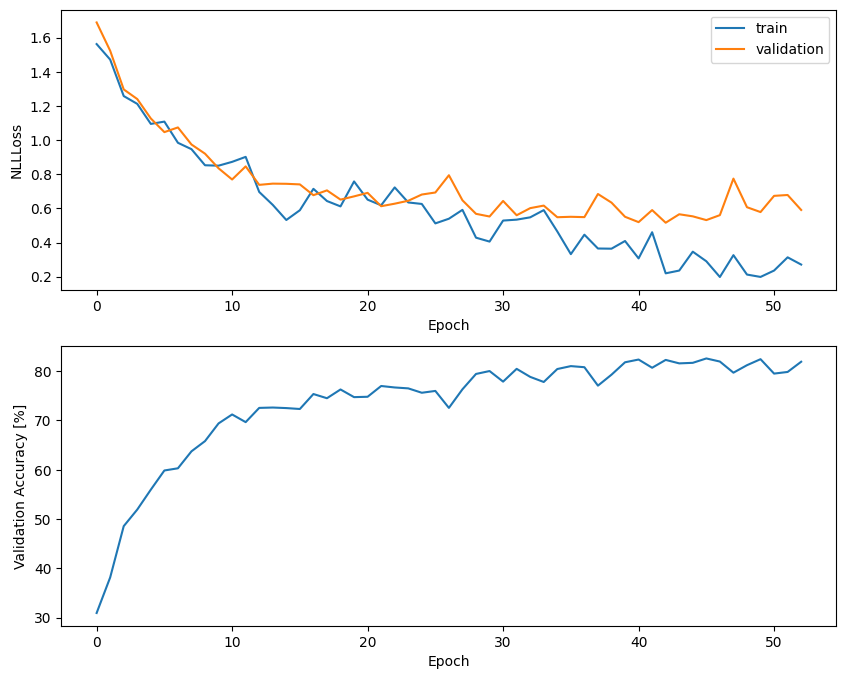

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(tr_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy [%]')
plt.plot(val_accs)

### Evaluation on test set + confusion matrix

In [19]:
# execute on test set

te_loss, te_acc, cm = test_epoch(test_loader, model, hparams)
print(f"  Test Loss: {te_loss:.4f}, Test Accuracy: {te_acc:.2f}%")

  Test Loss: 0.5044, Test Accuracy: 83.11%


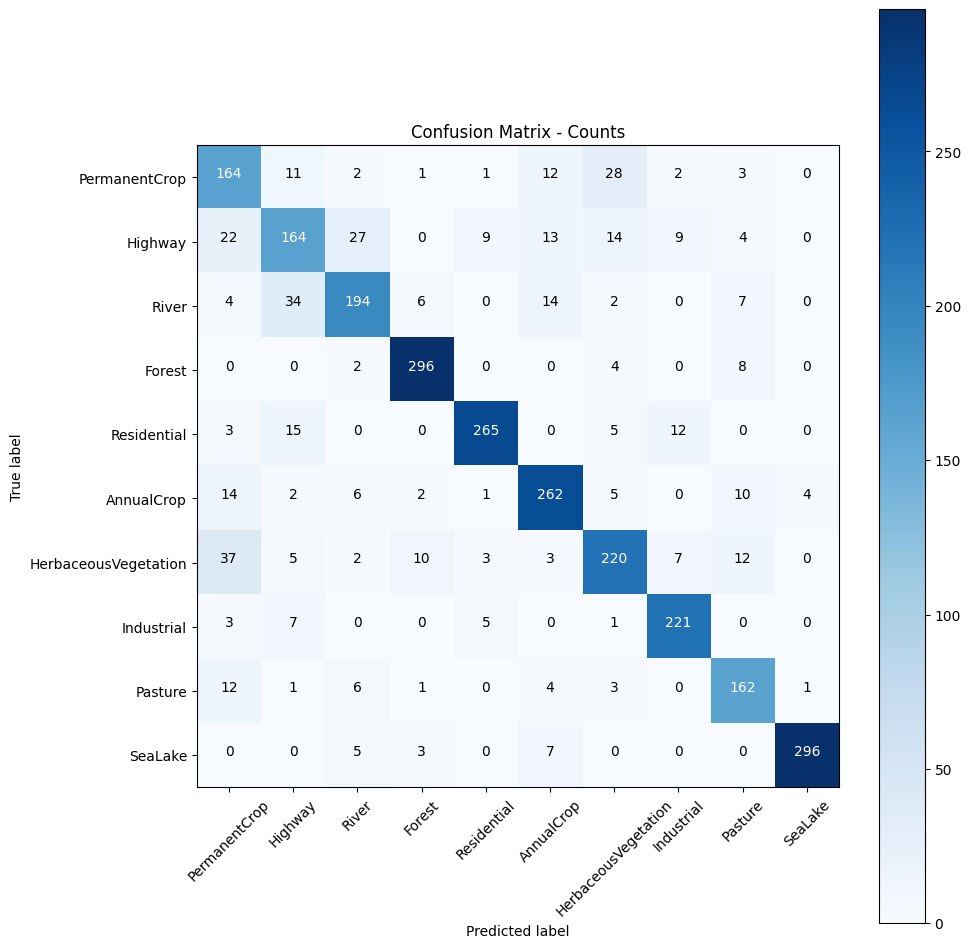

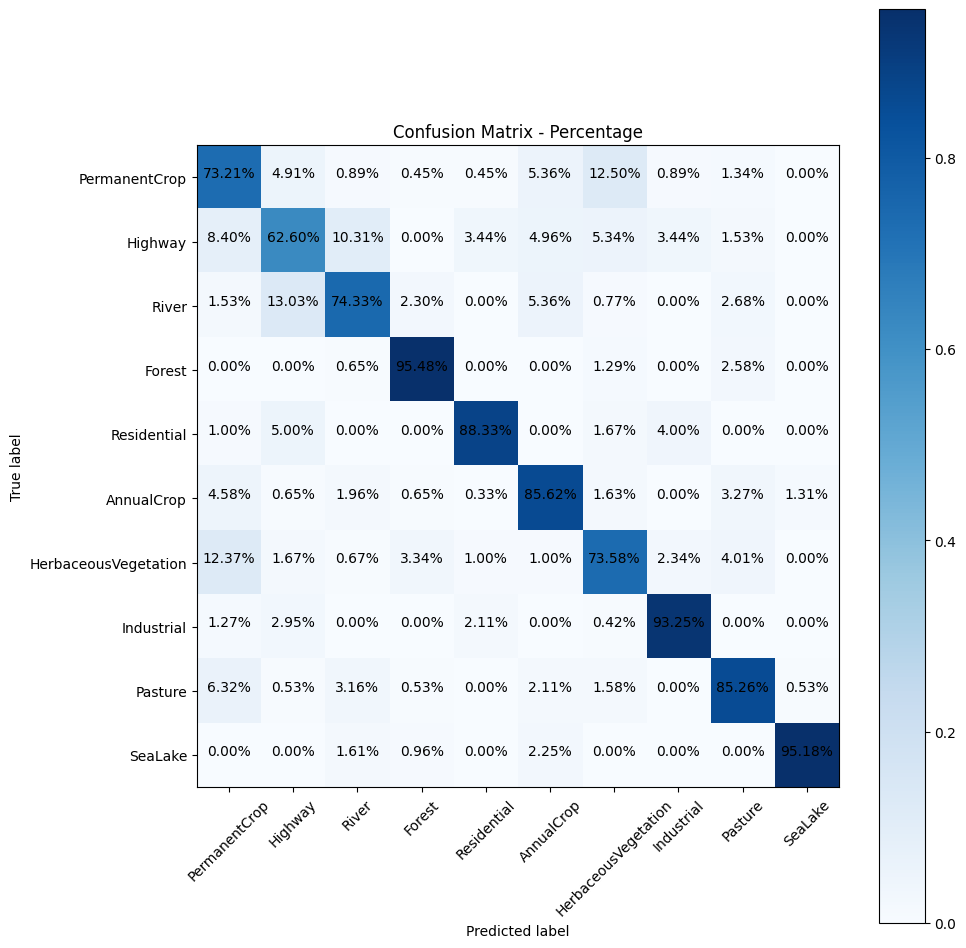

In [20]:
import itertools

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Counts')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot confusion matrix with percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Percentage')
plt.colorbar()
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm_percentage.shape[0]), range(cm_percentage.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm_percentage[i, j] * 100),
             horizontalalignment="center",
             color="white" if cm_percentage[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()